# **Linear Ordering Problem (LOP)**
### Search heuristics - KISA 2022
### *Naroa Mendez Olarra & Unai Sainz de la Maza Gamboa*


## Part1: Description and Objective function

#### Problem Description
The problem we are solving is called Linear Ordering Problem. In this problem, we are given a matrix $B = [b_{ij}]_{i,j=1,...,n}$ of non-negative numbers. The objective in this problem is to find the joint permutation $\sigma = (\sigma(1)\sigma(2)...\sigma(n))$ of rows and columns that maximises the sum of the numbers above the main diagonal of the matrix.

#### Data
The data given to solve the problem is a matrix $B = [b_{ij}]_{i,j=1,...,n}$ of non-negative numbers, where 
$n$ is equal to the number of rows and columns of the matrix.

#### Possible solution
A permutation $\sigma = (\sigma(1)\sigma(2)...\sigma(n))$ would be a possible solution of the problem.

#### Search space
The search space is all the possible different permutations of size $n$. The size of this search space is $\Omega = n!$

#### Objective function
Given a permutation, the objective function is written as follows:  $f(\sigma)=\sum_{i=1}^{n-1}\sum_{j=i+1}^n b_{\sigma(i)\sigma(j)}$

#### Table of Contents
TODO!
First of all, we have written a function that reads an instance of the LOP problem. Then, we have implemented the objective function and another function that calculates the fitness value of a neighbour. Finally, we have written some example cases.

In [2]:
# Install the dependencies
#!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 3.7 MB/s eta 0:00:00a 0:00:01


In [15]:
# Import the dependencies
import numpy as np
import random
import matplotlib.pyplot as plt
import more_itertools as mit
from time import time
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
import pandas as pd
import random
import time as tm
import pathlib as pl
import math
from glob import glob


In [4]:
# Define the path to the instances
instances_path = 'Instances'
std_instances_path = f'{instances_path}/std'
big_instances_path = f'{instances_path}/big'

In [5]:
def read_instance_LOP(filepath):
    """
    Read the instance file and return the size of the problem and the matrix B
    """
    # TODO: rewrite using with(open(filepath)) as fp and try-catch?
    fp = open(filepath)
    line = fp.readline()
    values = line.split()
    size = int(values[0])
    B = np.zeros((size, size))
    for i in range(size):
        line = fp.readline()
        values = line.split()
        for j in range(size):
            B[i][j] = int(values[j])
    fp.close()
    return (size, B)

In [6]:
def obj_func_LOP(solution, instance):
    """
    Calculate the objective function of the solution, where the
    complexity of this (naive) approach is O(n^2)
    """
    size = instance[0]
    B = instance[1]
    value = 0

    for i in range(size - 1):
        for j in range(i + 1, size):
            value += B[solution[i], solution[j]]

    return value


def swap_ngb_obj_func_LOP(instance, solution, prev_fitness, i, j):
    """
    Calculate the swap neighborhood objective function of the solution,
    we use prev_fitness to avoid recalculate the objective function.
    """
    B = instance[1]
    value = prev_fitness

    if j < i:
        i, j = j, i

    # O(n)
    for k in range(i + 1, j):  # [i+1, j) -- j is not included
        # horizontal part
        value -= B[solution[i], solution[k]]  # Remove extracted values
        value += B[solution[j], solution[k]]  # Sum added values (symmetric part)

        # vertical part
        value -= B[solution[k], solution[j]]  # Remove extracted values
        value += B[solution[k], solution[i]]  # Sum added values (symmetric part)

    # If i and j are adjacent values, we skip the for loop, in this case the
    # complexity will be O(1)
    # Last value, where intersects the vertical and horizontal lines
    value -= B[solution[i], solution[j]]  # Remove extracted values
    value += B[solution[j], solution[i]]  # Sum added values (symmetric part)

    return value

In [6]:
instance = read_instance_LOP(f"{std_instances_path}/Cebe.lop.n20.4")

solution = [
    i for i in range(instance[0])
]  # row == column

# Evaluate the solutions
result = obj_func_LOP(solution, instance)
print(f"Objective value of the solution is {result}")

Objective value of the solution is 30369.0


In [7]:
size = instance[0]
result2 = swap_ngb_obj_func_LOP(instance, solution, result, 0, 1)
result22 = swap_ngb_obj_func_LOP(instance, solution, result, size - 2, size - 1)
result23 = swap_ngb_obj_func_LOP(instance, solution, result, 0, size - 1)
print(f'original: {result}')
print(f'swap(0, 1): {result2}')
print(f'swap(last-2, last-1): {result22}')
print(f'swap(0, last-1): {result23}')


original: 30369.0
swap(0, 1): 30372.0
swap(last-2, last-1): 30374.0
swap(0, last-1): 28634.0


In [7]:
def random_search(instance, max_evals):
    """
    Random search algorithm for the LOP with max_evals evaluations
    """
    size = instance[0]
    best_solution = list(mit.random_permutation(range(size)))
    best_fitness = obj_func_LOP(best_solution, instance)
    max_evals -= 1
    
    while max_evals > 0:
        new_sol = list(mit.random_permutation(range(size)))
        new_fit = obj_func_LOP(new_sol, instance)
        if new_fit > best_fitness:
            best_solution = new_sol
            best_fitness = new_fit
        max_evals -= 1
    
    return (best_fitness, best_solution, max_evals)

In [9]:
best_fitness, best_solution, evals = random_search(instance, max_evals=1e5)
print(f'Best solution (permutation): {best_solution}')
print(f'Best fitness: {best_fitness}')
print(f'Number of evaluations used: {1e5 - evals}')

Best solution (permutation): [14, 10, 7, 16, 2, 3, 4, 11, 6, 18, 9, 19, 17, 12, 0, 8, 1, 5, 13, 15]
Best fitness: 48494.0
Number of evaluations used: 100000.0


## Part 2: Local Search

In [8]:
def constructive_initial_sol(instance, k=3):
    """
    Generate a constructive initial solution for the LOP problem.
    """
    size = instance[0]
    B = instance[1]
    val_index = [(np.sum(B[i, :]) / np.sum(B[:, i])) for i in range(size)]
    solution = []
    sort_i = np.argsort(-1 * np.array(val_index)).tolist()  # * -1 for descending order
    while len(sort_i) > 0:
        options = sort_i[: (min(k, len(sort_i)))]
        total_value = np.sum(
            [val_index[options[kk]] for kk in range(min(k, len(sort_i)))]
        )
        indexes = []
        indexes.append(val_index[options[0]] / total_value)
        for kk in range(1, (min(k, len(sort_i)))):
            indexes.append((val_index[options[kk]] / total_value) + indexes[kk - 1])
        random_number = random.random()
        for kk in range(min(k, len(sort_i))):
            if random_number < indexes[kk]:
                solution.append(options[kk])
                sort_i.pop(kk)
                break

    return solution

In [9]:
def swap(solution, i, j):
    """
    Neighbourhood: Swap the rows and columns of the solution with indices i and j
    """
    solution[i], solution[j] = solution[j], solution[i]
    return solution


def local_search(instance, evals, constructive_solution=True):
    """
    Local search algorithm for the LOP with evals evaluations,
    and a constructive initial solution if constructive_solution is True.
    """
    size = instance[0]
    best_solution = (
        constructive_initial_sol(instance, k=3)
        if constructive_solution
        else list(mit.random_permutation(range(size)))
    )

    best_fitness = obj_func_LOP(best_solution, instance)
    evals -= 1

    while evals > 0:
        improvement = False
        for i in range(size):
            for j in range(i + 1, size):
                new_fitness = swap_ngb_obj_func_LOP(
                    instance, best_solution, best_fitness, i, j
                )
                evals -= 1
                if new_fitness > best_fitness:
                    best_solution = swap(best_solution, i, j)
                    best_fitness = new_fitness
                    improvement = True
                    break  # best first
                else:
                    if evals <= 0:
                        break
            if improvement:
                break
        if not improvement:  # local optimum 
            break
    return (best_fitness, best_solution, evals)

In [12]:
(fitness, sol, evals) = local_search(instance, evals=1e5, constructive_solution=True)
print(f"- fitness: {fitness}\n- solution: {sol}\n- evals used: {1e5 - evals}")

- fitness: 50157.0
- solution: [14, 7, 3, 18, 16, 6, 9, 10, 8, 2, 1, 19, 11, 0, 13, 12, 4, 5, 17, 15]
- evals used: 3648.0


In [13]:
time_list = []
fit_l = []
for i in range(20):
    # random initial solution and 1e5 evaluations
    start = time()
    (fitness, sol, evals) = local_search(
        instance, evals=1e5, constructive_solution=False
    )
    end = time()
    time_list.append(end - start)
    fit_l.append(fitness)
print(
    "Fitness(μ ± σ):\t{:.3f}  ±  {:.3f}".format(
        float(np.mean(fit_l)), float(np.std(fit_l))
    )
)
print(
    "Time (μ ± σ):\t{:.6f}  ±  {:.6f}".format(
        float(np.mean(time_list)), float(np.std(time_list))
    )
)

Fitness(μ ± σ):	49847.400  ±  670.877
Time (μ ± σ):	0.022243  ±  0.008188


## Part3: Simulated Annealing

In [10]:
def simulated_annealing(
    instance,
    evals,
    constructive_solution=True,
    initial_temperature=1000,
    temperature_cooling=0.9,
    max_chain=100,
):
    size = instance[0]
    
    # Same as in local search
    best_solution = (
        constructive_initial_sol(instance, k=3)
        if constructive_solution
        else list(mit.random_permutation(range(size)))
    )

    best_fitness = obj_func_LOP(best_solution, instance)
    evals -= 1
    T = initial_temperature

    while T > 0.1 and evals > 0:  # stop condition
        chain_size = 0
        while chain_size < max_chain and evals > 0:  # equilibrium
            i, j = random.randint(0, size - 1), random.randint(0, size - 1)
            if i == j:
                if i != size - 1:
                    j += 1
                else:
                    i -= 1
            new_fitness = swap_ngb_obj_func_LOP(
                instance, best_solution, best_fitness, i, j
            )
            deltaE = new_fitness - best_fitness
            if deltaE > 0:
                best_solution = swap(best_solution, i, j)
                best_fitness = new_fitness
            else:
                probability = math.exp(deltaE / T)
                if probability > random.random():
                    best_solution = swap(best_solution, i, j)
                    best_fitness = new_fitness
            chain_size += 1
            evals -= 1
        T = T * temperature_cooling  # Geometric schedule
    return (best_fitness, best_solution, evals)

In [15]:
time_list = []
fit_l = []
for i in range(10):
    start = time()
    (fitness, sol, evals) = simulated_annealing(
        instance, evals=10000, constructive_solution=False
    )
    end = time()
    time_list.append(end - start)
    fit_l.append(fitness)
print(
    "Fitness(μ ± σ):\t{:.3f}  ±  {:.3f}".format(
        float(np.mean(fit_l)), float(np.std(fit_l))
    )
)
print(
    "Time (μ ± σ):\t{:.6f}  ±  {:.6f}".format(
        float(np.mean(time_list)), float(np.std(time_list))
    )
)

Fitness(μ ± σ):	50406.300  ±  145.752
Time (μ ± σ):	0.054909  ±  0.001164


## Part 4: Genetic algorithm

In [11]:
def genetic_algorithm(
    instance, evals, population_size=100, mutation_prob=0.1, max_patience=10
):
    def get_roulette(F):
        roulette = []  # range [0-1] values, ordered
        last_val = 0
        npF = np.asarray(F)
        sumF = np.sum(npF)

        for f in npF:
            last_val = last_val + f / sumF
            roulette.append(last_val)
        return roulette

    def find_near_val_index(lista, value):
        for i, v in enumerate(lista):
            if value <= v:
                return i

    def select(roulette):
        # roulette selection
        pos = []
        for _ in ["mom", "dad"]:
            r = random.random()
            ind = find_near_val_index(roulette, r)
            pos.append(ind)

        return pos[0], pos[1]

    def mutation(indiv):
        # swap random i and j
        i, j = random.randint(0, size - 1), random.randint(0, size - 1)
        if i == j:
            if i != size - 1:
                j += 1
            else:
                i -= 1
        indiv = swap(indiv, i, j)
        return indiv

    # Order crossover
    def reproduce(P, mom, dad):
        index1 = random.randint(0, size - 1)
        index2 = random.randint(index1, size)

        marked_out1 = P[mom][index1:index2]  # naranja
        marked_out2 = P[dad][index1:index2]

        rest_1 = [x for x in P[mom] if x not in set(marked_out2)]
        rest_2 = [x for x in P[dad] if x not in set(marked_out1)]  # azul

        son1 = rest_1[:index1] + marked_out2 + rest_1[index1:]
        son2 = rest_2[:index1] + marked_out1 + rest_2[index1:]  # child1

        # mutation
        if random.random() <= mutation_prob:
            son1 = mutation(son1)
        if random.random() <= mutation_prob:
            son2 = mutation(son2)
        return son1, son2

    def evaluate(P, instance, evals):
        F = []  # actual fitness of each individual
        if evals > population_size:
            for act in range(population_size):
                v = obj_func_LOP(P[act], instance)
                F.append(v)
            evals -= population_size
        else:
            for act in range(evals):
                v = obj_func_LOP(P[act], instance)
                F.append(v)
            evals = 0
        return F, evals

    size = instance[0]
    patience = 0
    best_fitness = 0
    P = []  # actual population
    F = []  # actual fitness of each individual
    odd_population = population_size % 2 == 1

    # First generation
    for _ in range(population_size):
        sol = list(mit.random_permutation(range(size)))
        P.append(sol)
    
    F, evals = evaluate(P, instance, evals)
    while patience < max_patience and evals > 0:  # stop_criterion
        sons = []
        roulette = get_roulette(F)
        for i in range(population_size // 2):
            mom_i, dad_i = select(roulette)
            son1, son2 = reproduce(P, mom_i, dad_i)
            sons = sons + [son1, son2]
        if odd_population:
            mom_i, dad_i = select(P, roulette)
            son1, _ = reproduce(P, mom_i, dad_i)
            sons = sons + [son1]

        sons[0] = P[
            F.index(max(F))
        ]  # substitute first son with the previous generation best individual, elitism
        P = sons
        F, evals = evaluate(P, instance, evals)
        if max(F) > best_fitness:
            best_fitness = max(F)
            patience = 0
        else:
            patience += 1

    i = F.index(max(F))
    best_solution = P[i]
    best_fitness = F[i]

    return (best_fitness, best_solution, evals)

In [17]:
(fitness, sol, evals) = genetic_algorithm(
    instance, evals=10000, population_size=10, mutation_prob=0.1, max_patience=10
)
print(f"- fitness: {fitness}\n- solution: {sol}\n- evals used: {10000 - evals}")

- fitness: 48697.0
- solution: [14, 7, 3, 4, 2, 10, 1, 16, 11, 0, 6, 8, 5, 18, 17, 15, 19, 12, 9, 13]
- evals used: 870


In [18]:
time_list = []
fit_l = []
for i in range(10):
    start = time()
    (fitness, sol, evals) = genetic_algorithm(
        instance, evals=10000, population_size=10, mutation_prob=0.1, max_patience=10
    )
    end = time()
    time_list.append(end - start)
    fit_l.append(fitness)
print(
    "Fitness(μ ± σ):\t{:.3f}  ±  {:.3f}".format(
        float(np.mean(fit_l)), float(np.std(fit_l))
    )
)
print(
    "Time (μ ± σ):\t{:.6f}  ±  {:.6f}".format(
        float(np.mean(time_list)), float(np.std(time_list))
    )
)

Fitness(μ ± σ):	46891.700  ±  2239.201
Time (μ ± σ):	0.020313  ±  0.011386


## Part 5: experimentation

### Parameter Tuning Process

In [19]:
instance_20 = read_instance_LOP(f"{std_instances_path}/Cebe.lop.n20.4")
instance_30 = read_instance_LOP(f"{std_instances_path}/Cebe.lop.n30.3")

In [20]:
N_RUNS = 10

#### Simulated Annealing

In [27]:
max_evals = 50000
initial_temperatures = [100, 500, 1500, 2500]
temperature_cooling = [0.75, 0.9, 0.95]
max_chain = [50, 100, 500, 750]

##### Instance 20

In [28]:
print("Initial temperature \t Cooling \t max_chain \t Fitness(μ ± σ) \t evals")
avg_fitnesses = []
deviations = []
list_initial_temperatures = []
list_coolings = []
list_max_chain = []

for tmp in initial_temperatures:
    for cooling in temperature_cooling:
        for chain in max_chain:
            time_list = []
            fit_l = []
            for i in range(N_RUNS):
                start = time()
                (fitness, sol, evals) = simulated_annealing(
                    instance_20,
                    evals=max_evals,
                    constructive_solution=False,
                    initial_temperature=tmp,
                    temperature_cooling=cooling,
                    max_chain=chain,
                )
                end = time()
                time_list.append(end - start)
                fit_l.append(fitness)
            list_initial_temperatures.append(tmp)
            list_coolings.append(cooling)
            list_max_chain.append(chain)
            avg_fitnesses.append(np.mean(fit_l))
            deviations.append(np.std(fit_l))
            print(
                "{:^20} \t {:^8} \t {:^10} \t{:.3f}  ±  {:.3f} \t {:^6}".format(
                    tmp,
                    cooling,
                    chain,
                    float(np.mean(fit_l)),
                    float(np.std(fit_l)),
                    max_evals - evals,
                )
            )
            # print("Time (μ ± σ):\t{:.6f}  ±  {:.6f}".format(float(np.mean(time_list)), float(np.std(time_list))))


Initial temperature 	 Cooling 	 max_chain 	 Fitness(μ ± σ) 	 evals
        100          	   0.75   	     50     	49992.600  ±  235.483 	  1251 
        100          	   0.75   	    100     	49952.200  ±  480.100 	  2501 
        100          	   0.75   	    500     	50398.700  ±  114.018 	 12501 
        100          	   0.75   	    750     	50386.100  ±  440.330 	 18751 
        100          	   0.9    	     50     	50123.600  ±  276.086 	  3301 
        100          	   0.9    	    100     	50027.900  ±  466.722 	  6601 
        100          	   0.9    	    500     	50483.600  ±  148.400 	 33001 
        100          	   0.9    	    750     	50514.900  ±  151.688 	 49501 
        100          	   0.95   	     50     	50278.400  ±  232.860 	  6751 
        100          	   0.95   	    100     	50390.100  ±  118.960 	 13501 
        100          	   0.95   	    500     	50436.400  ±  108.358 	 50000 
        100          	   0.95   	    750     	50546.200  ±  116.375 	 50000 
        5

    Initial temperature  Cooling  Max_chain  Average fitness  Standard deviation
31                 1500     0.90        750          50561.1          129.483937
22                  500     0.95        500          50555.2          118.169201
43                 2500     0.90        750          50549.0          124.855116
11                  100     0.95        750          50546.2          116.375083
15                  500     0.75        750          50533.5          139.240978
34                 1500     0.95        500          50527.4           95.772856
7                   100     0.90        750          50514.9          151.688134
19                  500     0.90        750          50504.0          103.877813
45                 2500     0.95        100          50485.4          123.136672
6                   100     0.90        500          50483.6          148.400270
42                 2500     0.90        500          50477.6          144.285966
39                 2500     

<AxesSubplot: xlabel='Initial temperature', ylabel='Cooling-Max_chain'>

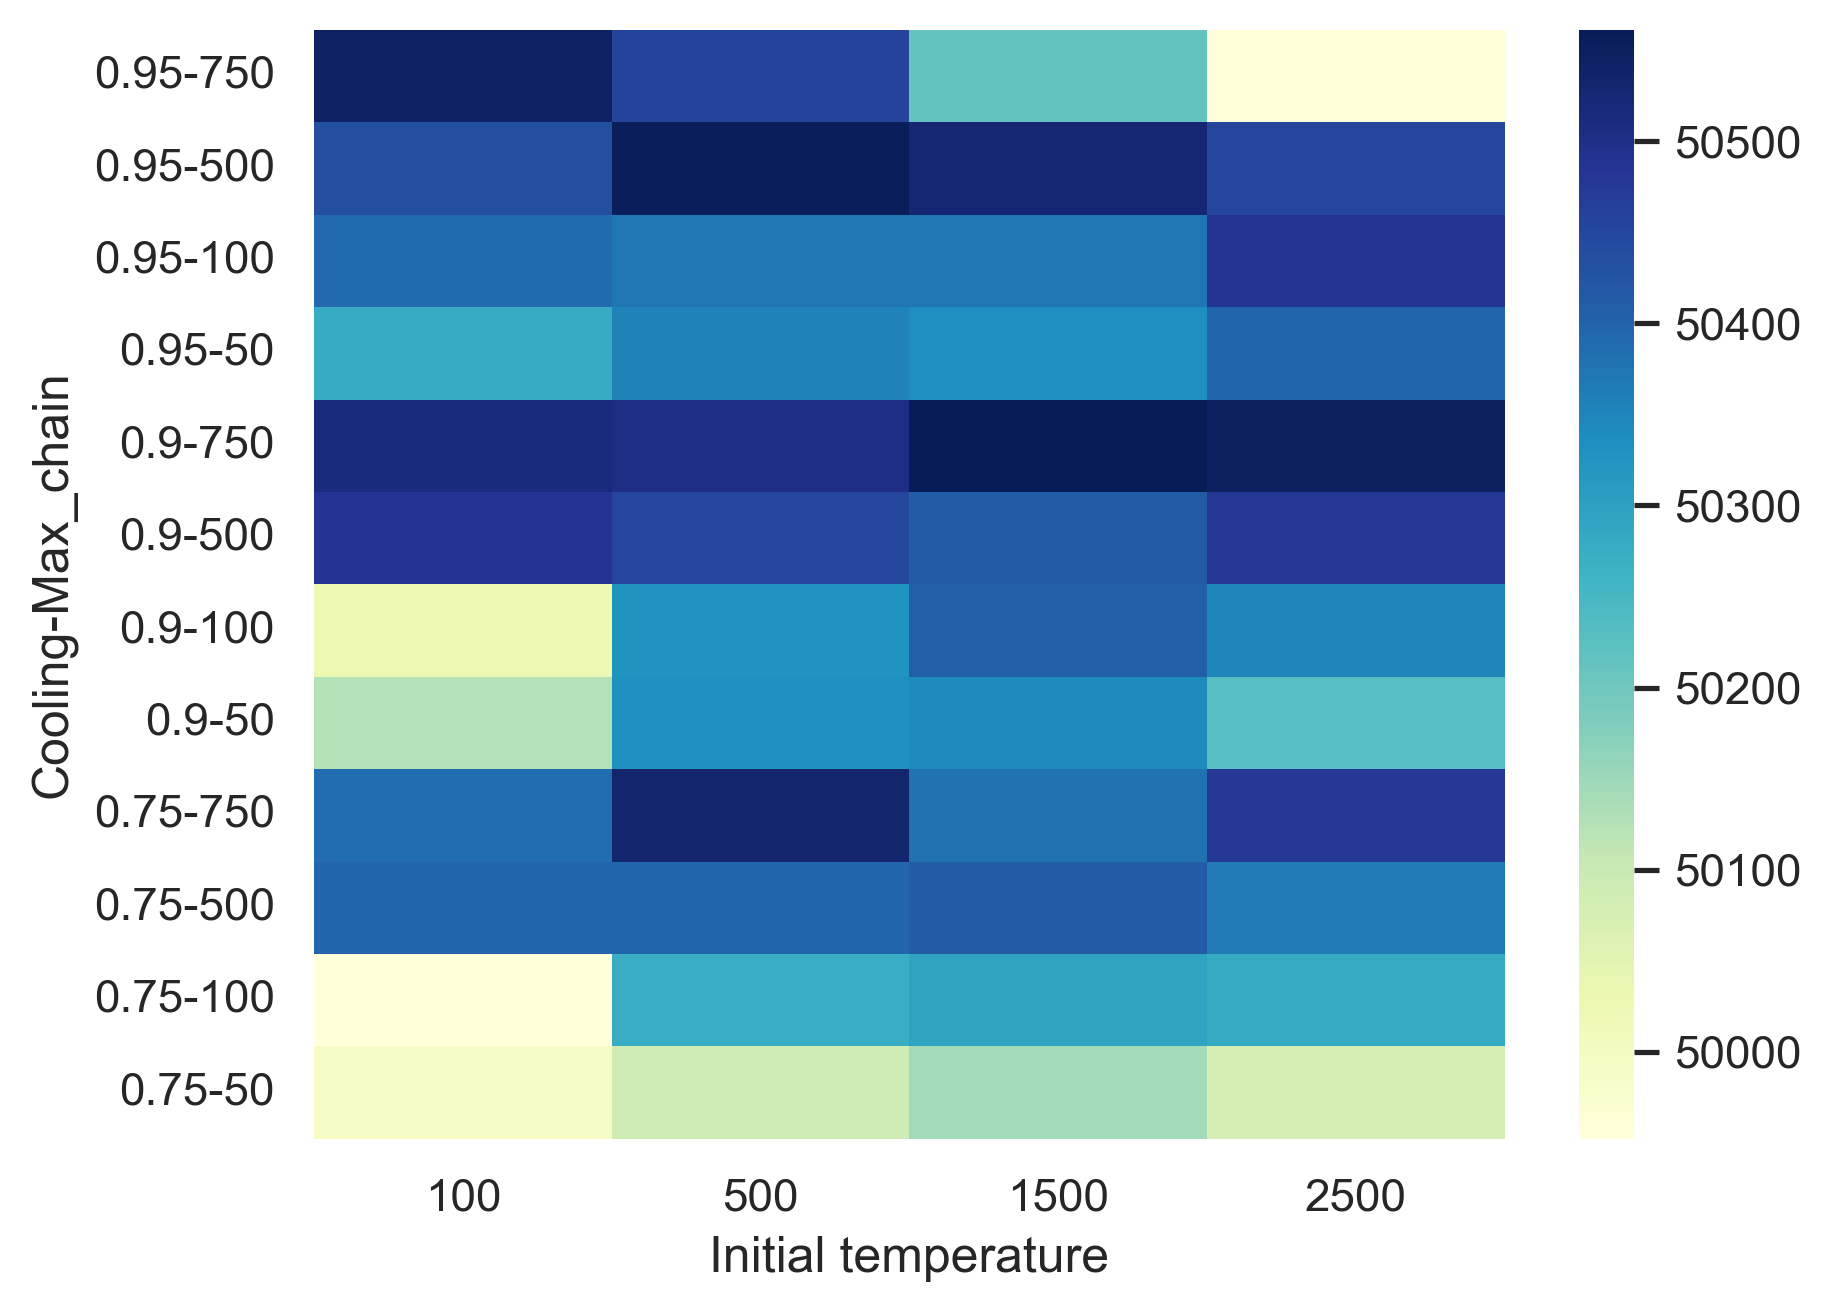

In [29]:
pd.set_option("expand_frame_repr", False)
datos = pd.DataFrame(
    {
        "Initial temperature": list_initial_temperatures,
        "Cooling": list_coolings,
        "Max_chain": list_max_chain,
        "Average fitness": avg_fitnesses,
        "Standard deviation": deviations,
    }
)
datos.sort_values(
    by=["Average fitness"], inplace=True, ascending=False
)
print(datos)
datos = datos.pivot(
    index=["Cooling", "Max_chain"],
    columns=[
        "Initial temperature",
    ],
    values="Average fitness",
)
datos.sort_index(axis=0, ascending=False, inplace=True)
sns.heatmap(datos, cmap="YlGnBu")

# BEST: Temperatura init (1500), cooling (0.90) y max_chain (750).
# Fitness: 50596.2  ±  72.696

##### Instance 30

In [24]:
print("Initial temperature \t Cooling \t max_chain \t Fitness(μ ± σ) \t evals")

avg_fitnesses = []
deviations = []
list_initial_temperatures = []
list_coolings = []
list_max_chain = []

for tmp in initial_temperatures:
    for cooling in temperature_cooling:
        for chain in max_chain:
            time_list = []
            fit_l = []
            for i in range(N_RUNS):
                start = time()
                (fitness, sol, evals) = simulated_annealing(
                    instance_30,
                    evals=max_evals,
                    constructive_solution=False,
                    initial_temperature=tmp,
                    temperature_cooling=cooling,
                    max_chain=chain,
                )
                end = time()
                time_list.append(end - start)
                fit_l.append(fitness)
            list_initial_temperatures.append(tmp)
            list_coolings.append(cooling)
            list_max_chain.append(chain)
            avg_fitnesses.append(np.mean(fit_l))
            deviations.append(np.std(fit_l))
            print(
                "{:^20} \t {:^8} \t {:^10} \t{:.3f}  ±  {:.3f} \t {:^6}".format(
                    tmp,
                    cooling,
                    chain,
                    float(np.mean(fit_l)),
                    float(np.std(fit_l)),
                    max_evals - evals,
                )
            )
            # print("Time (μ ± σ):\t{:.6f}  ±  {:.6f}".format(float(np.mean(time_list)), float(np.std(time_list))))

Initial temperature 	 Cooling 	 max_chain 	 Fitness(μ ± σ) 	 evals
        100          	   0.75   	     50     	58924.800  ±  314.323 	  1251 
        100          	   0.75   	    100     	58937.100  ±  313.691 	  2501 
        100          	   0.75   	    500     	60222.900  ±  361.529 	 12501 
        100          	   0.75   	    750     	59799.400  ±  320.358 	 18751 
        100          	   0.9    	     50     	58964.900  ±  529.238 	  3301 
        100          	   0.9    	    100     	59555.100  ±  351.379 	  6601 
        100          	   0.9    	    500     	60061.400  ±  268.471 	 33001 
        100          	   0.9    	    750     	60333.300  ±  238.877 	 49501 
        100          	   0.95   	     50     	59511.400  ±  360.204 	  6751 
        100          	   0.95   	    100     	59798.500  ±  556.928 	 13501 
        100          	   0.95   	    500     	60215.700  ±  236.622 	 50000 
        100          	   0.95   	    750     	60381.000  ±  296.797 	 50000 
        5

    Initial temperature  Cooling  Max_chain  Average fitness  Standard deviation
22                  500     0.95        500          60571.9          223.817984
23                  500     0.95        750          60488.4          244.587081
31                 1500     0.90        750          60444.4          141.816924
15                  500     0.75        750          60389.2          212.791353
11                  100     0.95        750          60381.0          296.796563
7                   100     0.90        750          60333.3          238.876558
18                  500     0.90        500          60329.0          228.308125
39                 2500     0.75        750          60328.1          182.772782
34                 1500     0.95        500          60327.2          240.822258
19                  500     0.90        750          60303.3          259.809565
43                 2500     0.90        750          60296.8          217.476803
46                 2500     

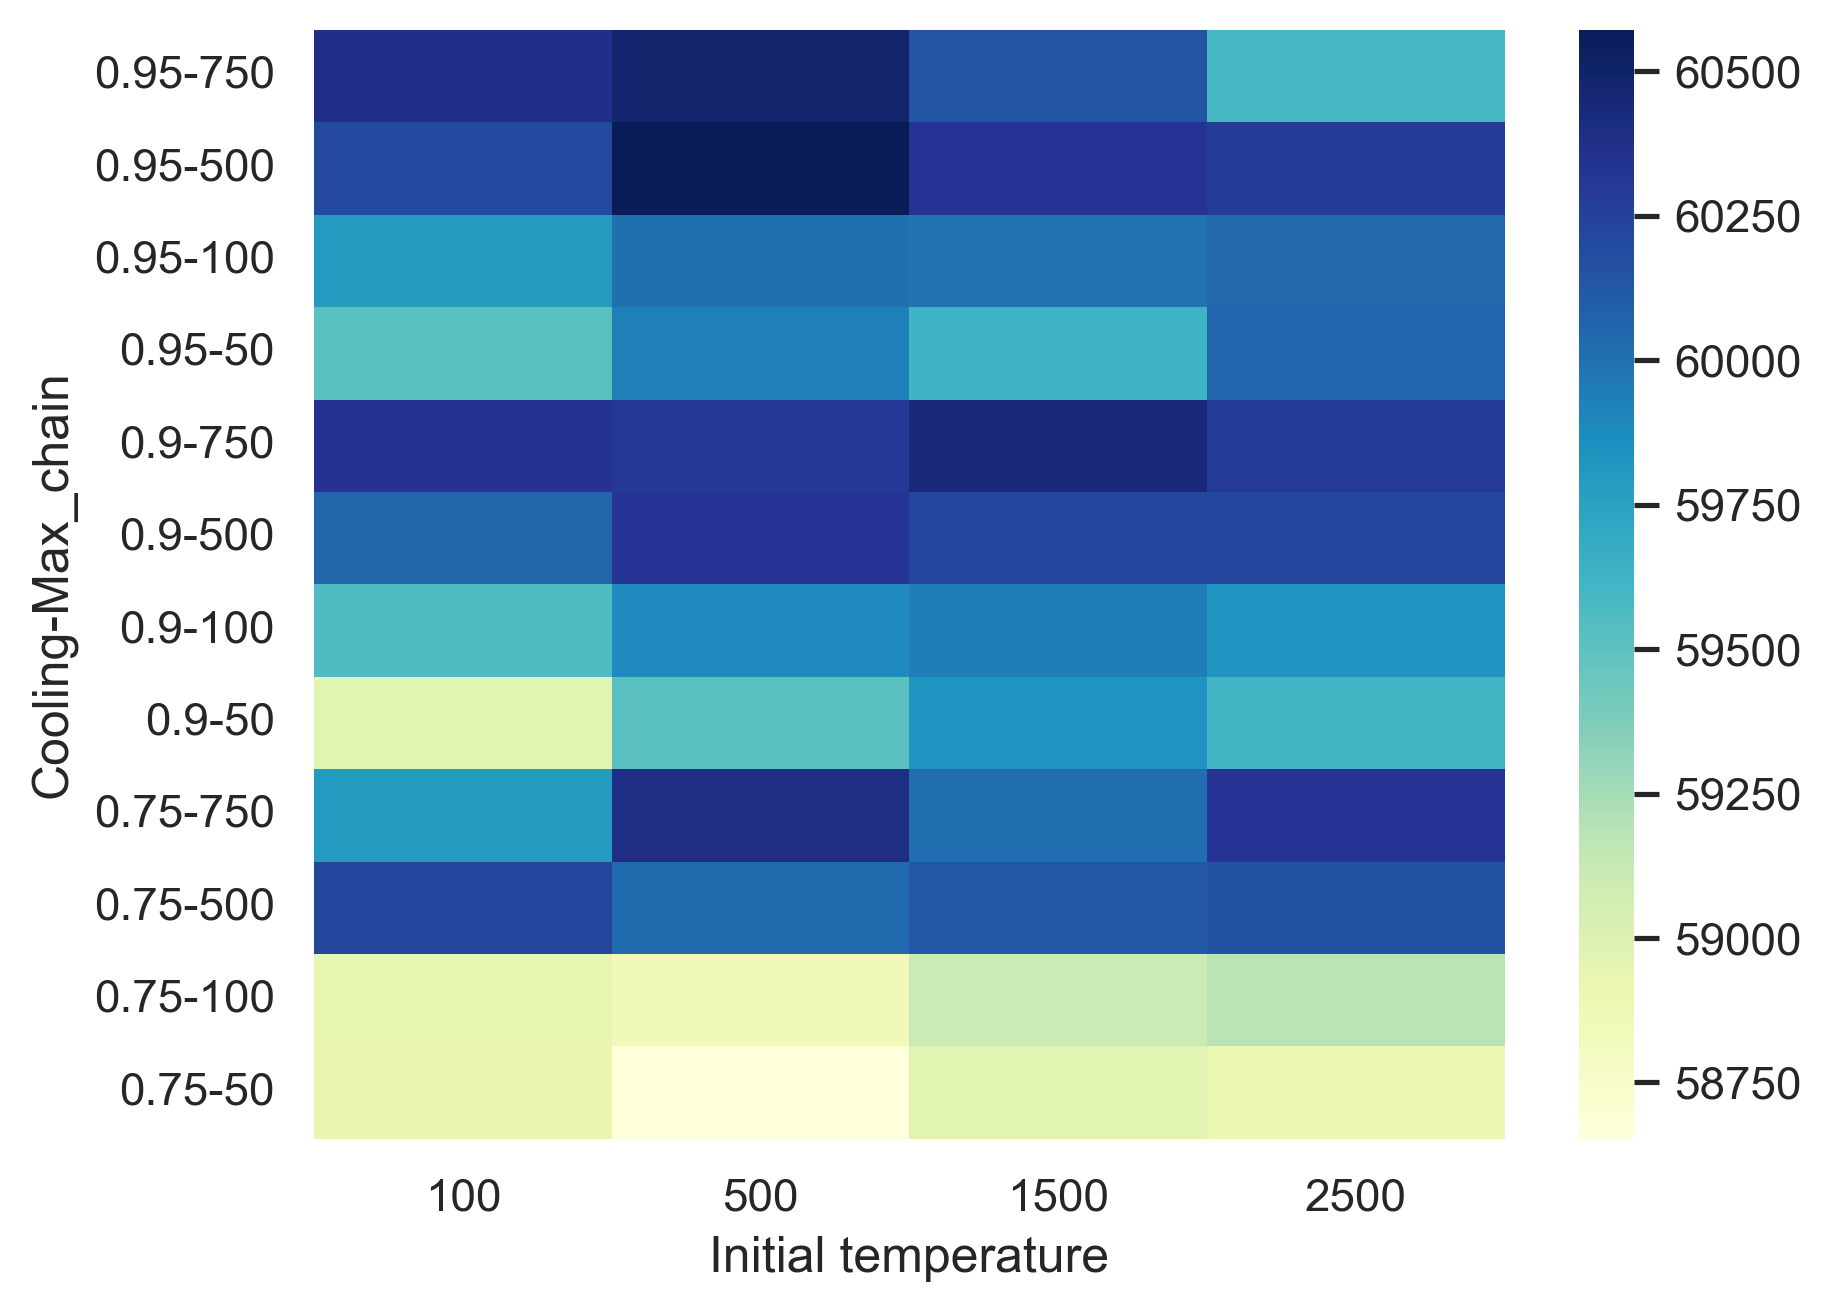

In [26]:
pd.set_option("expand_frame_repr", False)
datos = pd.DataFrame(
    {
        "Initial temperature": list_initial_temperatures,
        "Cooling": list_coolings,
        "Max_chain": list_max_chain,
        "Average fitness": avg_fitnesses,
        "Standard deviation": deviations,
    }
)
datos.sort_values(
    by=["Average fitness"], inplace=True, ascending=False
)
print(datos)
datos = datos.pivot(
    index=["Cooling", "Max_chain"],
    columns=[
        "Initial temperature",
    ],
    values="Average fitness",
)
datos.sort_index(axis=0, ascending=False, inplace=True)
sns.heatmap(datos, cmap="YlGnBu")
plt.savefig("heatmap_30.png", dpi=300)

# BEST: Temp init (500), cooling (0.95), max_chain (500).
# Fitness: 60571.9  ±  223.817

#### Genetic Algorithm

In [30]:
ax_evals = 20000
population_size = [10, 100, 500, 1000]
mutation_prob = [0.05, 0.1, 0.2, 0.3]
max_patiences = [10, 20, 40, 50]

##### Instance 20

In [31]:
list_populations_size = []
list_mutation_prob = []
list_patiences = []
list_avg_fit = []
list_avg_evals = []
list_avg_time = []

print("Population size \t mutation prob \t patience \t Fitness(μ ± σ) \t evals")
for pop_s in population_size:
    for mut_p in mutation_prob:
        for patience in max_patiences:
            time_list = []
            fit_l = []
            for i in range(N_RUNS):
                start = time()
                (fitness, sol, evals) = genetic_algorithm(
                    instance_20,
                    evals=max_evals,
                    population_size=pop_s,
                    mutation_prob=mut_p,
                    max_patience=patience,
                )
                end = time()
                time_list.append(end - start)
                fit_l.append(fitness)
            print(
                "{:^20} \t {:^8} \t {:^10} \t{:.1f}  ±  {:.1f} \t {:>6}".format(
                    pop_s,
                    mut_p,
                    patience,
                    float(np.mean(fit_l)),
                    float(np.std(fit_l)),
                    max_evals - evals,
                )
            )

            list_populations_size.append(pop_s)
            list_mutation_prob.append(mut_p)
            list_patiences.append(patience)
            list_avg_fit.append(float(np.mean(fit_l)))
            list_avg_time.append(float(np.mean(time_list)))
            list_avg_evals.append(max_evals - evals)


Population size 	 mutation prob 	 patience 	 Fitness(μ ± σ) 	 evals
         10          	   0.05   	     10     	45811.6  ±  1285.6 	    190
         10          	   0.05   	     20     	47295.5  ±  1272.5 	   1330
         10          	   0.05   	     40     	48898.1  ±  355.2 	   2310
         10          	   0.05   	     50     	49299.2  ±  551.6 	   2570
         10          	   0.1    	     10     	45242.8  ±  2136.7 	    120
         10          	   0.1    	     20     	48292.4  ±  1282.4 	    780
         10          	   0.1    	     40     	49129.0  ±  703.8 	   3170
         10          	   0.1    	     50     	49645.7  ±  438.3 	   1770
         10          	   0.2    	     10     	46374.5  ±  1409.7 	    290
         10          	   0.2    	     20     	48684.3  ±  1200.5 	   1150
         10          	   0.2    	     40     	49620.2  ±  494.6 	   1460
         10          	   0.2    	     50     	49933.4  ±  177.9 	   1640
         10          	   0.3    	     10     	4755

    Pop_size  Mutation_prob  Patience  Average fitness  Standard deviation
11        10           0.20        50          58073.8            0.371594
22       100           0.10        40          57583.3            2.096754
19       100           0.05        50          57296.5            3.008428
27       100           0.20        50          57234.2            2.545779
14        10           0.30        40          57102.9            0.274532
..       ...            ...       ...              ...                 ...
44       500           0.30        10          53452.1            2.083976
24       100           0.20        10          52985.5            0.396394
8         10           0.20        10          51285.1            0.041705
4         10           0.10        10          51137.8            0.061360
0         10           0.05        10          49368.2            0.038934

[64 rows x 5 columns]


<AxesSubplot: xlabel='Patience', ylabel='Pop_size-Mutation_prob'>

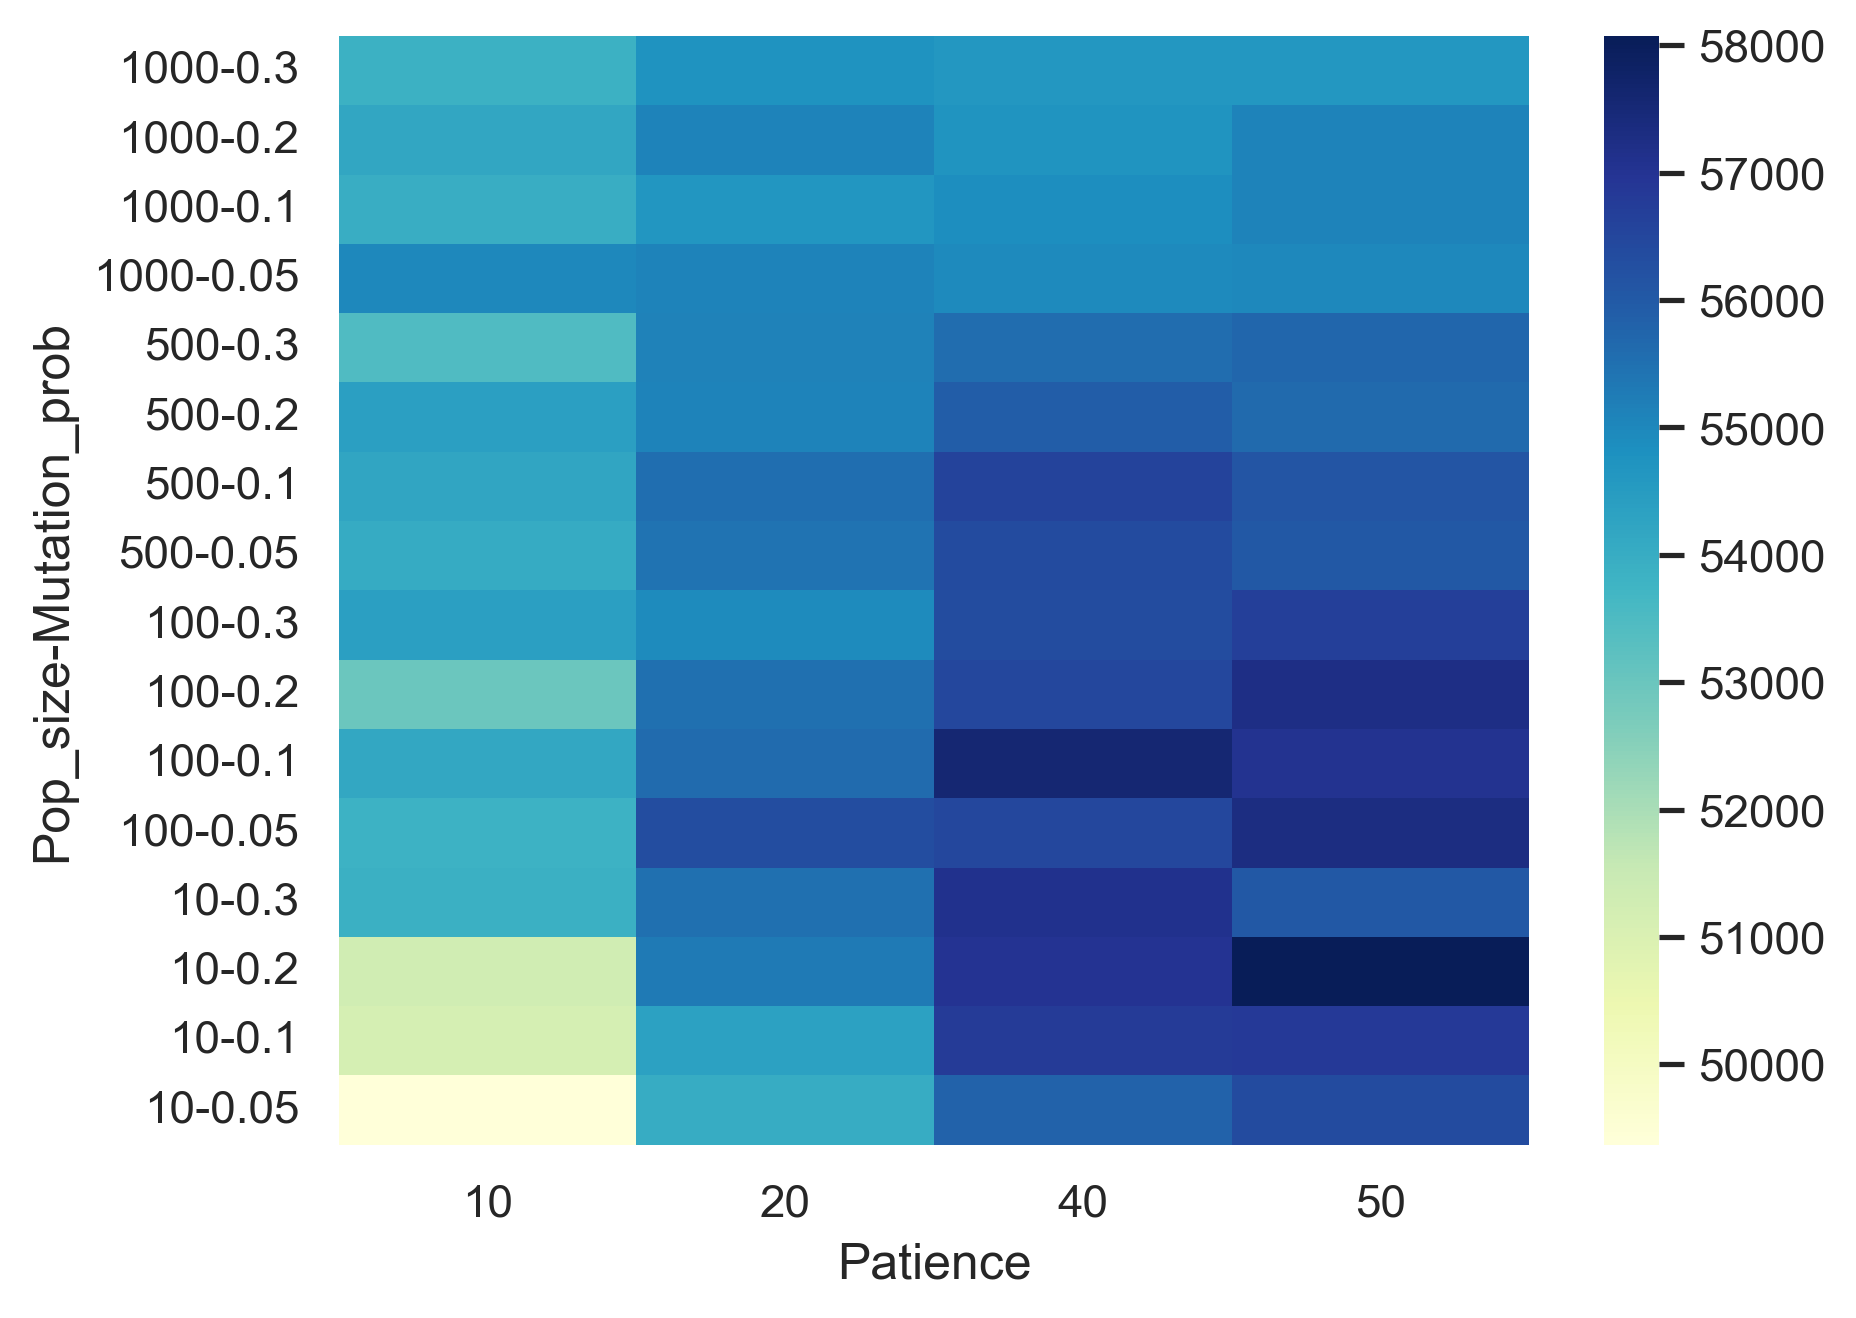

In [35]:
datos = pd.DataFrame(
    {
        "Pop_size": list_populations_size,
        "Mutation_prob": list_mutation_prob,
        "Patience": list_patiences,
        "Average fitness": list_avg_fit,
        "Standard deviation": list_avg_time,
    }
)
datos.sort_values(by=['Average fitness'], inplace=True, ascending=False)
print(datos)
datos = datos.pivot(
    index=["Pop_size", "Mutation_prob"],
    columns=[
        "Patience",
    ],
    values="Average fitness",
)
datos.sort_index(axis=0, ascending=False, inplace=True)
sns.heatmap(datos, cmap="YlGnBu")

##### Instance 30

In [33]:
list_populations_size = []
list_mutation_prob = []
list_patiences = []
list_avg_fit = []
list_avg_evals = []
list_avg_time = []

print("Population size \t mutation prob \t patience \t Fitness(μ ± σ) \t evals")
for pop_s in population_size:
    for mut_p in mutation_prob:
        for patience in max_patiences:
            time_list = []
            fit_l = []
            for i in range(N_RUNS):
                start = time()
                (fitness, sol, evals) = genetic_algorithm(
                    instance_30,
                    evals=max_evals,
                    population_size=pop_s,
                    mutation_prob=mut_p,
                    max_patience=patience,
                )
                end = time()
                time_list.append(end - start)
                fit_l.append(fitness)
            print(
                "{:^20} \t {:^8} \t {:^10} \t{:.1f}  ±  {:.1f} \t {:>6}".format(
                    pop_s,
                    mut_p,
                    patience,
                    float(np.mean(fit_l)),
                    float(np.std(fit_l)),
                    max_evals - evals,
                )
            )

            list_populations_size.append(pop_s)
            list_mutation_prob.append(mut_p)
            list_patiences.append(patience)
            list_avg_fit.append(float(np.mean(fit_l)))
            list_avg_time.append(float(np.mean(time_list)))
            list_avg_evals.append(max_evals - evals)

Population size 	 mutation prob 	 patience 	 Fitness(μ ± σ) 	 evals
         10          	   0.05   	     10     	49368.2  ±  3278.6 	    580
         10          	   0.05   	     20     	54003.0  ±  2310.3 	   1850
         10          	   0.05   	     40     	55795.7  ±  1823.7 	   2630
         10          	   0.05   	     50     	56396.0  ±  1876.3 	   5840
         10          	   0.1    	     10     	51137.8  ±  2573.3 	    750
         10          	   0.1    	     20     	54348.9  ±  1374.1 	   1180
         10          	   0.1    	     40     	56789.1  ±  1097.9 	   3120
         10          	   0.1    	     50     	56848.5  ±  1309.5 	   4630
         10          	   0.2    	     10     	51285.1  ±  1261.6 	    330
         10          	   0.2    	     20     	55296.6  ±  998.5 	   1750
         10          	   0.2    	     40     	57012.5  ±  1571.8 	   2530
         10          	   0.2    	     50     	58073.8  ±  815.4 	   4670
         10          	   0.3    	     10     	

    Pop_size  Mutation_prob  Patience  Average fitness
11        10           0.20        50          58073.8
22       100           0.10        40          57583.3
19       100           0.05        50          57296.5
27       100           0.20        50          57234.2
14        10           0.30        40          57102.9
..       ...            ...       ...              ...
44       500           0.30        10          53452.1
24       100           0.20        10          52985.5
8         10           0.20        10          51285.1
4         10           0.10        10          51137.8
0         10           0.05        10          49368.2

[64 rows x 4 columns]


<AxesSubplot: xlabel='Patience', ylabel='Pop_size-Mutation_prob'>

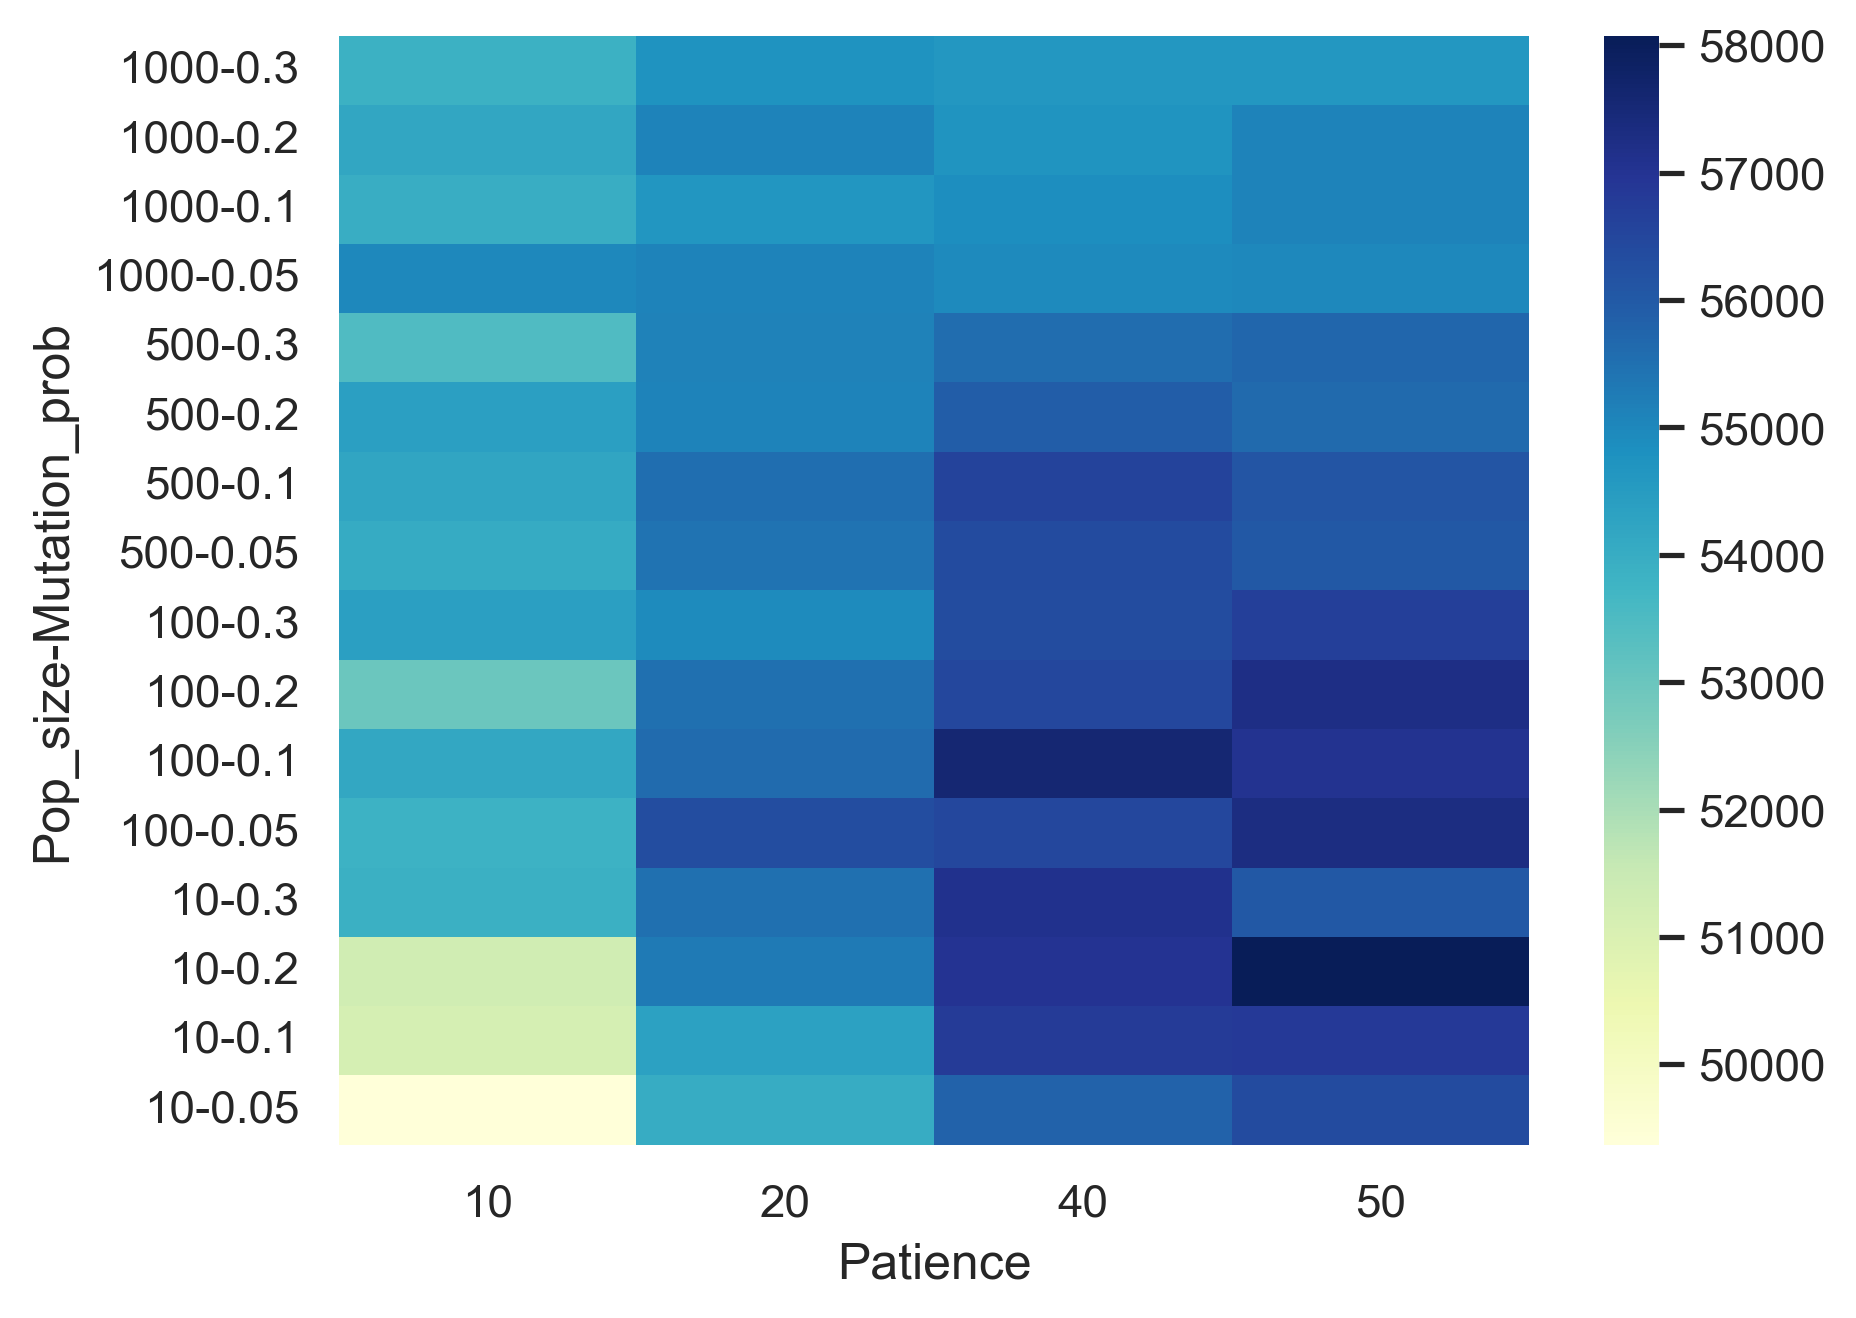

In [34]:
datos = pd.DataFrame(
    {
        "Pop_size": list_populations_size,
        "Mutation_prob": list_mutation_prob,
        "Patience": list_patiences,
        "Average fitness": list_avg_fit,
    }
)
datos.sort_values(by=['Average fitness'], inplace=True, ascending=False)
print(datos)
datos = datos.pivot(
    index=["Pop_size", "Mutation_prob"],
    columns=[
        "Patience",
    ],
    values="Average fitness",
)

datos.sort_index(axis=0, ascending=False, inplace=True)
sns.heatmap(datos, cmap="YlGnBu")

### Execution time

#### Objective function

In [3]:
sizes = [1, 100, 1000, 10000]
time_list_standard = []
time_list_optimized = []

for size in sizes:
    instance = []

    sol = list(mit.random_permutation(range(size)))
    instance.append(size)
    instance.append(np.ones((size,) * 2))

    # Standard
    start = time()
    obj_func_LOP(sol, instance)
    end = time()
    time_list_standard.append(end - start)

    # Optimized objective function for swap neighborhood
    start = time()
    swap_ngb_obj_func_LOP(instance, sol, 50, 0, size - 1)
    end = time()
    time_list_optimized.append(end - start)


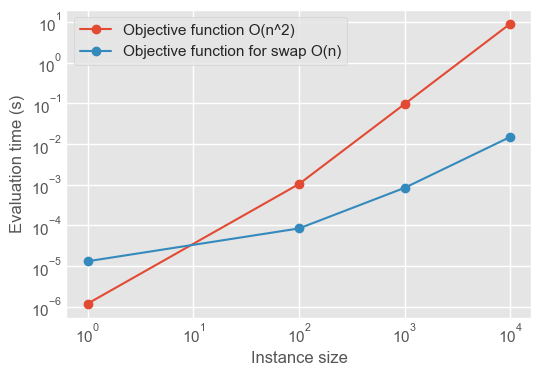

In [24]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(6, 4))
    plt.tick_params(axis='both', which='major', length=0)
    plt.plot(
        sizes,
        time_list_standard, 
        marker="o", 
        label="Objective function O(n^2)"
    )
    plt.plot(
        sizes,
        time_list_optimized,
        marker="o",
        label="Objective function for swap O(n)",
    )
    plt.xlabel("Instance size")
    plt.ylabel("Evaluation time (s)")
    #plt.title("Execution time of the objective functions")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()
    plt.savefig("time_complexity_obj_func.pdf", bbox_inches="tight")
    plt.show()

#### Evaluations Analysis

In [36]:
RS_time_list = []
LS_time_list = []
GA_time_list = []
SA_time_list = []
RS_fit_list = []
LS_fit_list = []
GA_fit_list = []
SA_fit_list = []
evaluations = [10**i for i in range(7)]

for max_evals in evaluations:
    print(f"max_evals: {max_evals}")
    RS_fit_l = []
    LS_fit_l = []
    GA_fit_l = []
    SA_fit_l = []
    RS_time_l = []
    LS_time_l = []
    GA_time_l = []
    SA_time_l = []
    for i in range(N_RUNS):
        start = time()
        (fitness, sol, evals) = random_search(instance, max_evals=max_evals)  # baseline
        RS_time_l.append(time() - start)
        RS_fit_l.append(fitness)

        start = time()
        (fitness, sol, evals) = local_search(
            instance, evals=max_evals, constructive_solution=False
        )
        LS_time_l.append(time() - start)
        LS_fit_l.append(fitness)

        start = time()
        (fitness, sol, evals) = simulated_annealing(
            instance,
            evals=max_evals,
            initial_temperature=500,
            temperature_cooling=0.95,
            max_chain=500,
            constructive_solution=False,
        )
        SA_time_l.append(time() - start)
        SA_fit_l.append(fitness)
        start = time()
        (fitness, sol, evals) = genetic_algorithm(
            instance,
            evals=max_evals,
            population_size=10,
            mutation_prob=0.1,
            max_patience=50,
        )
        GA_time_l.append(time() - start)
        GA_fit_l.append(fitness)

    RS_time_list.append(float(np.mean(RS_time_l)))
    LS_time_list.append(float(np.mean(LS_time_l)))
    GA_time_list.append(float(np.mean(GA_time_l)))
    SA_time_list.append(float(np.mean(SA_time_l)))
    RS_fit_list.append(float(np.mean(RS_fit_l)))
    LS_fit_list.append(float(np.mean(LS_fit_l)))
    GA_fit_list.append(float(np.mean(GA_fit_l)))
    SA_fit_list.append(float(np.mean(SA_fit_l)))


max_evals: 1
max_evals: 10
max_evals: 100
max_evals: 1000
max_evals: 10000
max_evals: 100000
max_evals: 1000000


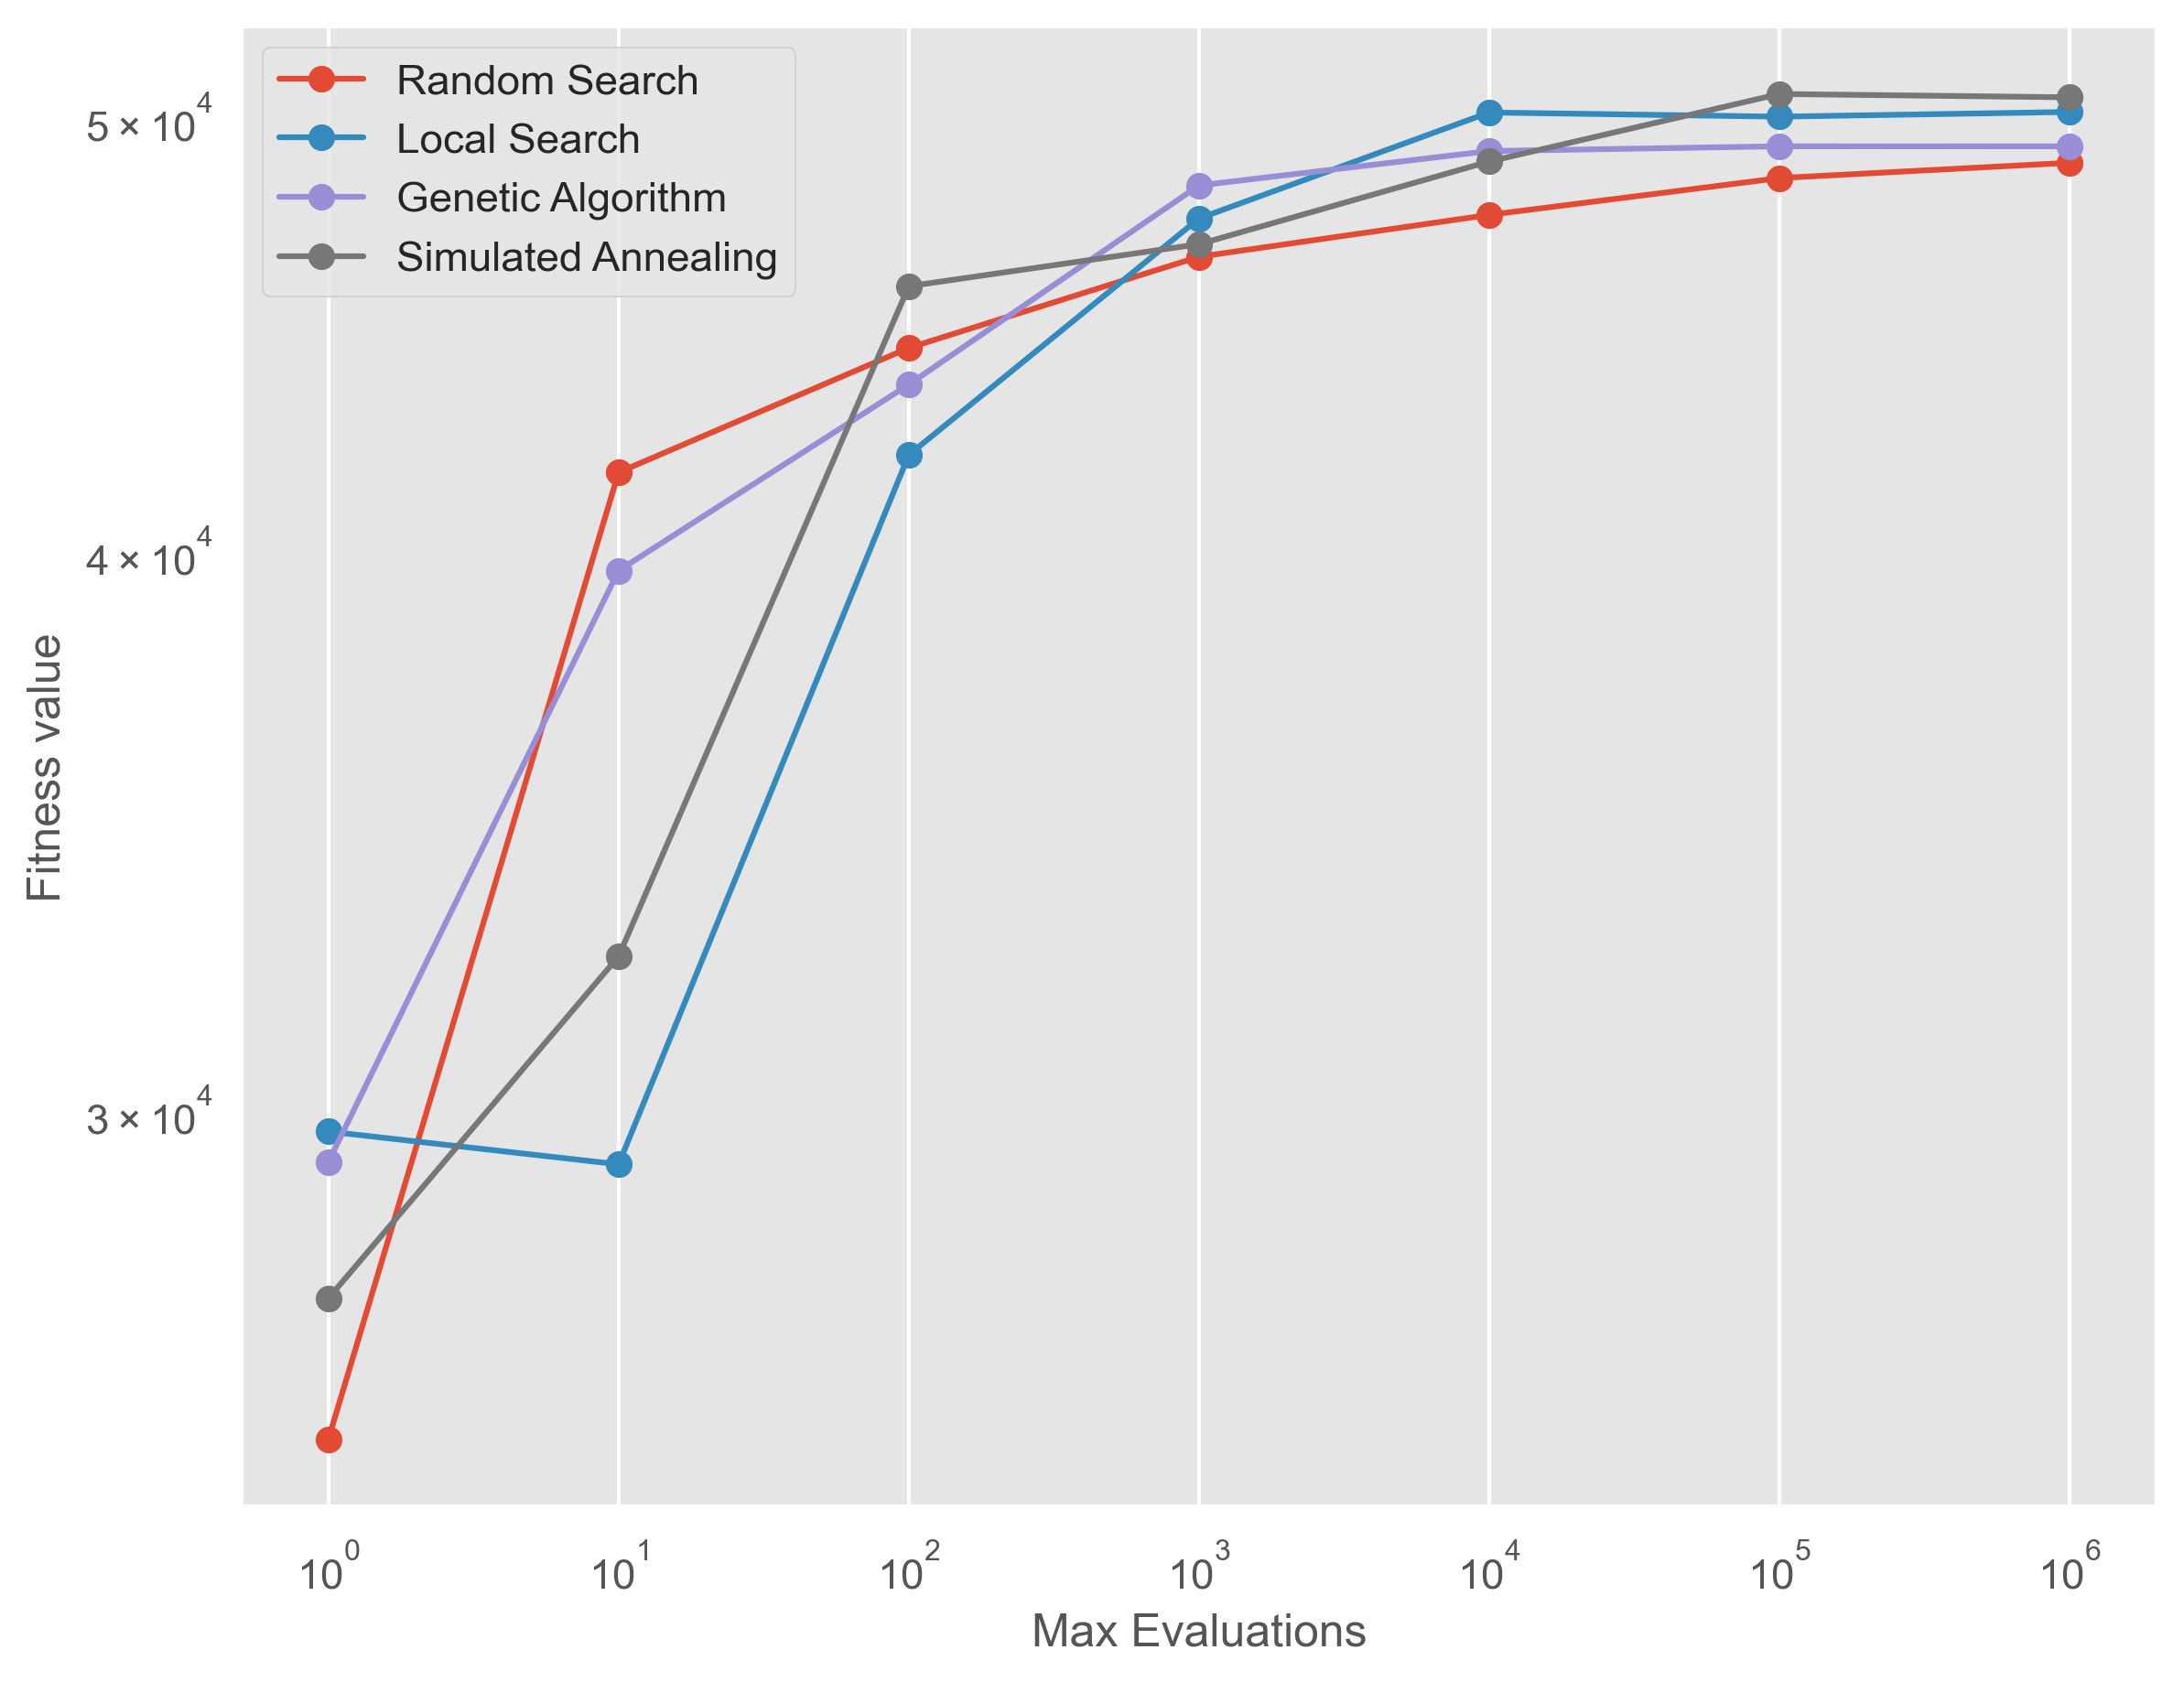

In [39]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(9, 7))
    plt.plot(evaluations, RS_fit_list, marker='o', label="Random Search")
    plt.plot(evaluations, LS_fit_list, marker='o', label="Local Search")
    plt.plot(evaluations, GA_fit_list, marker='o', label="Genetic Algorithm")
    plt.plot(evaluations, SA_fit_list, marker='o', label="Simulated Annealing")
    plt.ylabel('Fitness value')
    plt.xlabel('Max Evaluations')
    #plt.title("Fitness evolution vs max evaluations")
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.savefig("fit_maxevals.pdf", bbox_inches="tight")
    plt.show()

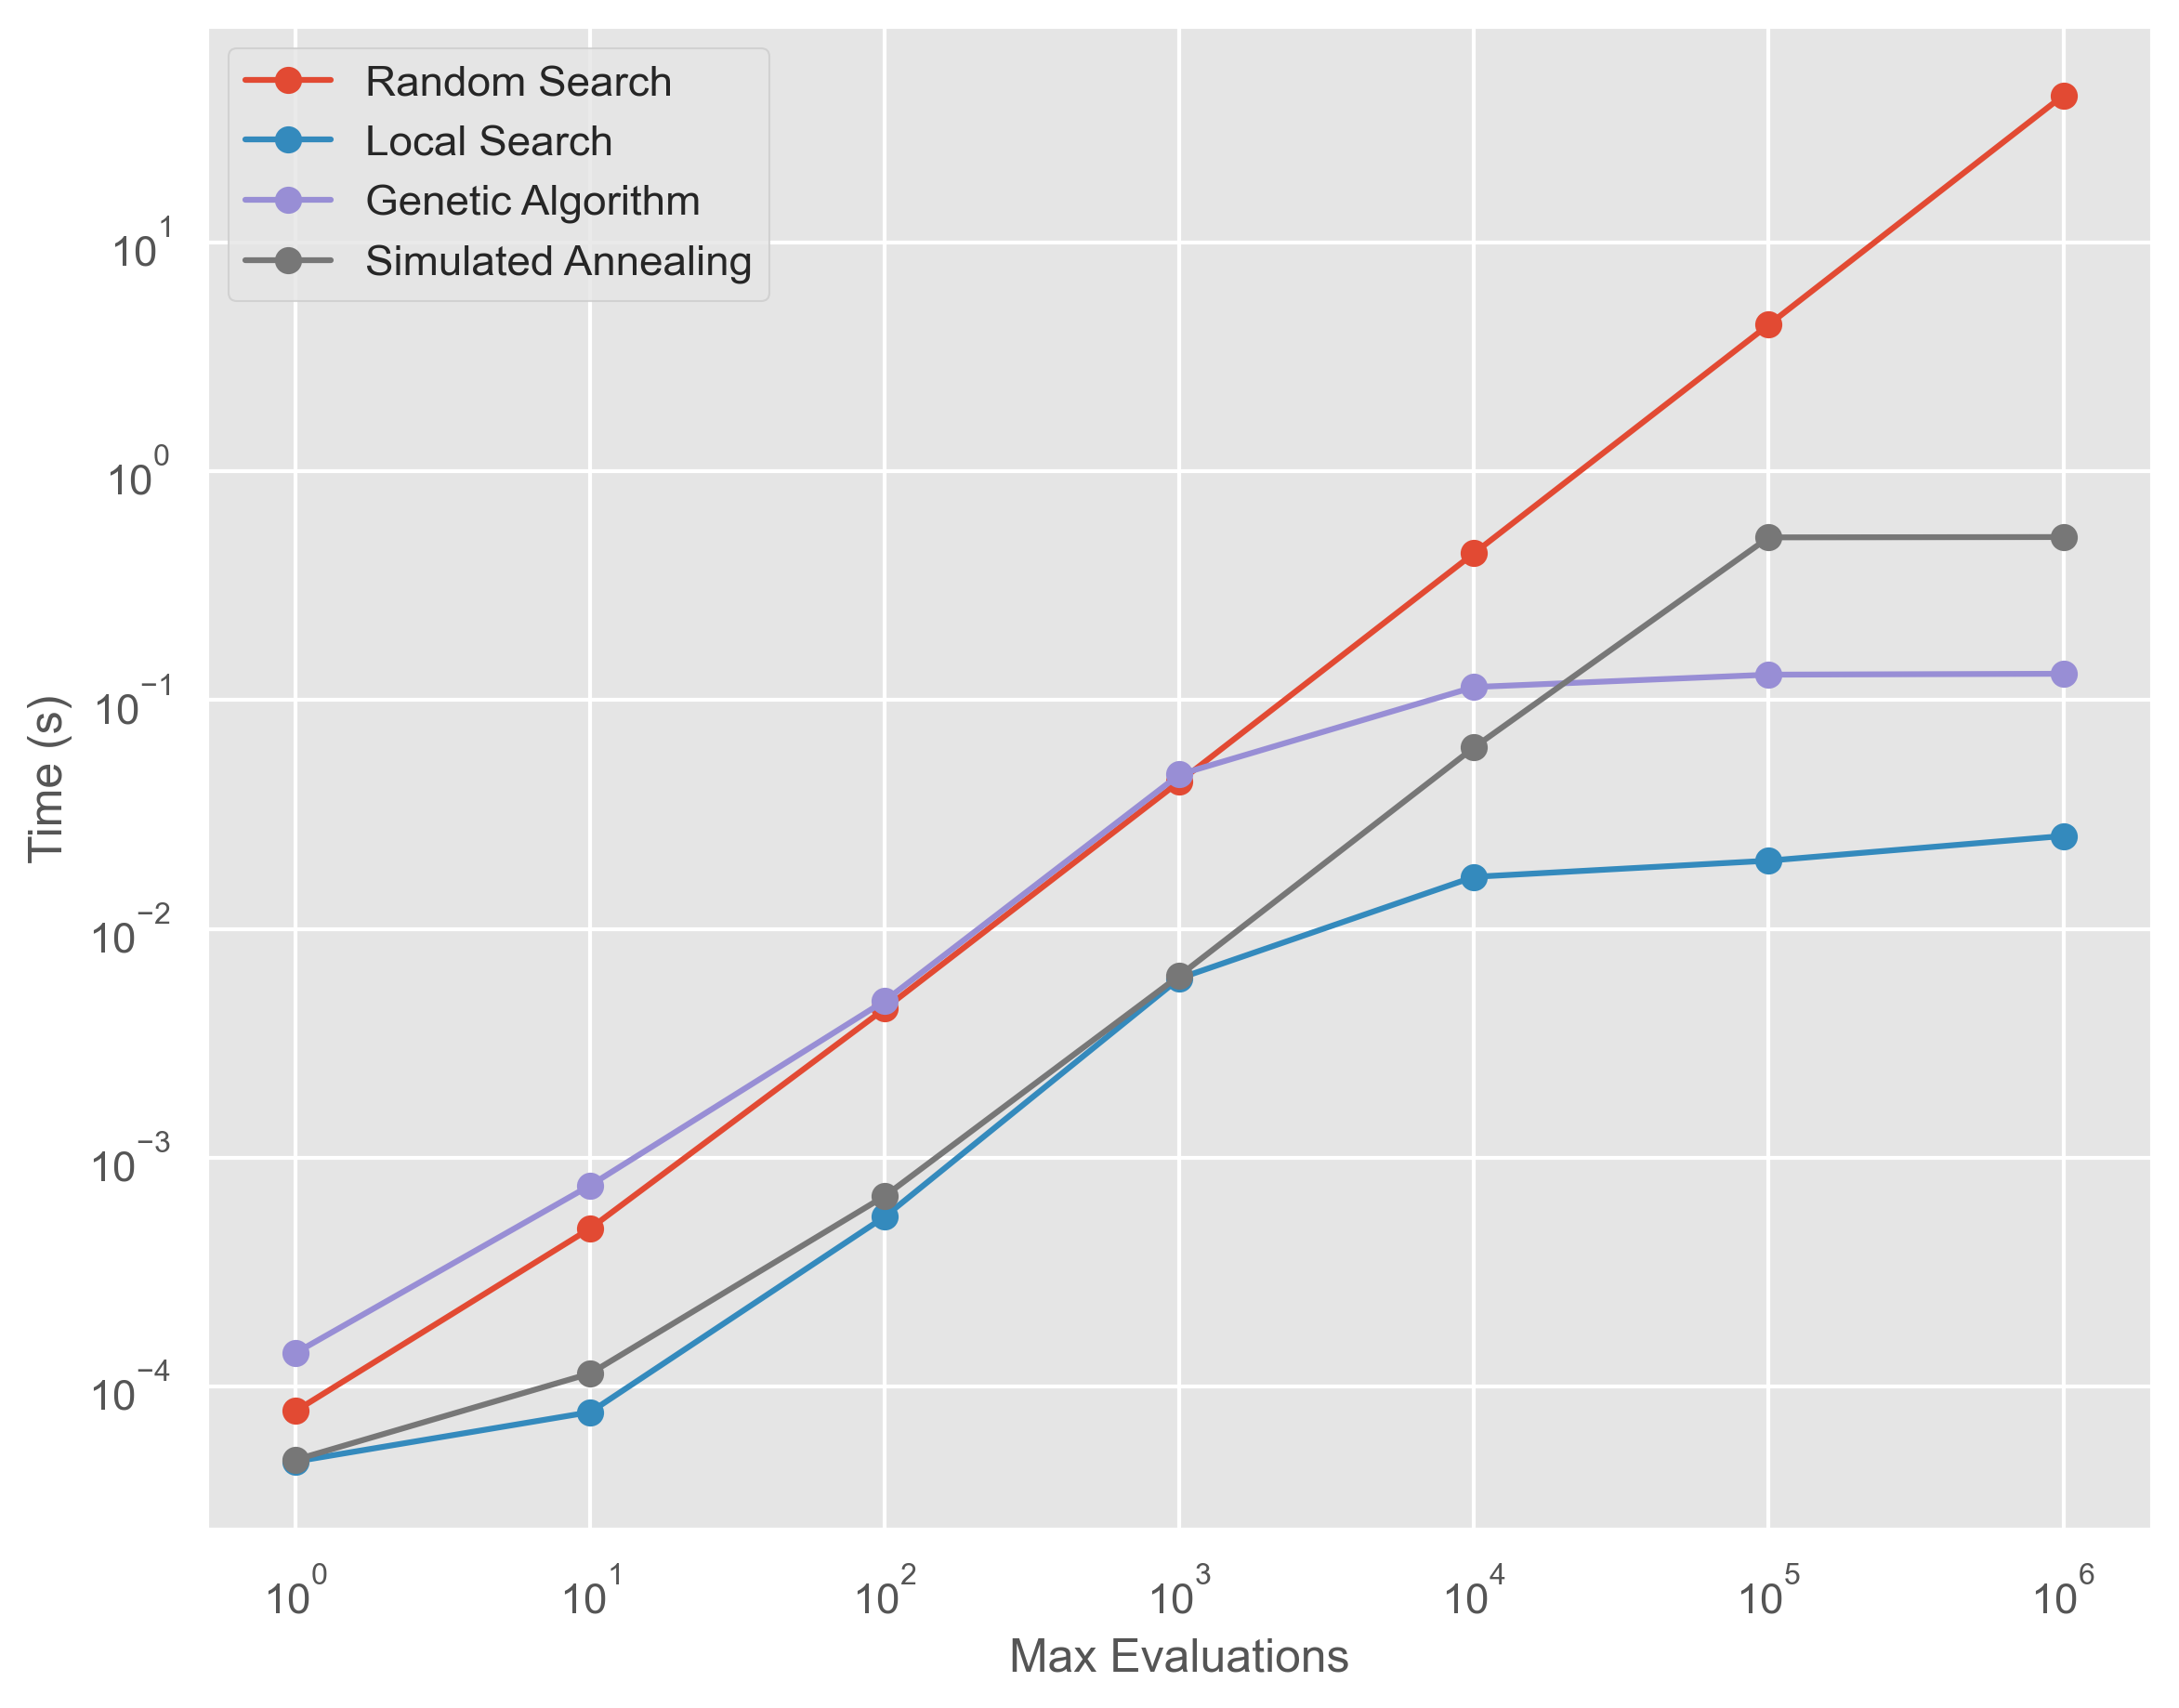

In [40]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(9, 7))
    plt.plot(evaluations, RS_time_list, marker="o", label="Random Search")
    plt.plot(evaluations, LS_time_list, marker="o", label="Local Search")
    plt.plot(evaluations, GA_time_list, marker="o", label="Genetic Algorithm")
    plt.plot(evaluations, SA_time_list, marker="o", label="Simulated Annealing")
    plt.ylabel("Time (s)")
    plt.xlabel("Max Evaluations")
    #plt.title("Time Evolution per maxEval")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()
    plt.savefig("time_maxevals.pdf", bbox_inches="tight")
    plt.show()


### Benchmarks
Multiple instances, multiple runs (higher number for smaller instances because of time restrictions). 

In [12]:
N_RUNS = 10

In [ ]:
max_evals = 20000

In [ ]:
files = glob("Instances/std/*.*")
files.sort()

fit_list_random = []
fit_list_local = []
fit_list_simulated = []
fit_list_genetic = []

for f in files:
    print(f)

    instance = read_instance_LOP(f)
    fit_l_random = []
    fit_l_local = []
    fit_l_simulated = []
    fit_l_genetic = []

    for i in range(N_RUNS):
        (fitness, sol, evals) = random_search(instance, max_evals=max_evals)  # baseline
        fit_l_random.append(fitness)
        
        (fitness, sol, evals) = local_search(
            instance, evals=max_evals, constructive_solution=False
        )
        fit_l_local.append(fitness)
        
        (fitness, sol, evals) = simulated_annealing(
            instance,
            evals=max_evals,
            initial_temperature=500,
            temperature_cooling=0.95,
            max_chain=500,
            constructive_solution=False,
        )
        fit_l_simulated.append(fitness)
        
        (fitness, sol, evals) = genetic_algorithm(
            instance,
            evals=max_evals,
            population_size=10,
            mutation_prob=0.1,
            max_patience=50,
        )
        fit_l_genetic.append(fitness)
    
    fit_list_random.append(fit_l_random)
    fit_list_local.append(fit_l_local)
    fit_list_simulated.append(fit_l_simulated)
    fit_list_genetic.append(fit_l_genetic)

In [ ]:
avgs_random = np.mean(fit_list_random, axis=1)
stds_random = np.std(fit_list_random, axis=1)

avgs_local = np.mean(fit_list_local, axis=1)
stds_local = np.std(fit_list_local, axis=1)

avgs_simulated = np.mean(fit_list_simulated, axis=1)
stds_simulated = np.std(fit_list_simulated, axis=1)

avgs_genetic = np.mean(fit_list_genetic, axis=1)
stds_genetic = np.std(fit_list_genetic, axis=1)

datos = pd.DataFrame(
    {
        "RS avg": avgs_random,
        "RS std": stds_random,
        "LS avg": avgs_local,
        "LS std": stds_local,
        "SA avg": avgs_simulated,
        "SA std": stds_simulated,
        "GA avg": avgs_genetic,
        "GA std": stds_genetic,
        "Instance": files,
    }
)
datos.sort_values(by=["Instance"], inplace=True, ascending=True)
print(datos)

In [12]:
try:
    datos.to_csv("Normal_Instance_avg_std.csv")
    df = pd.DataFrame(
        {
            "Random Search": fit_list_random,
            "Local Search": fit_list_local,
            "Simulated Annealing": fit_list_simulated,
            "Genetic Algorithm": fit_list_genetic
        }
    )
    df.to_csv("Normal_Instance_Results.csv")
except:
    pass

#### BIG instances

In [17]:
max_evals = 10000

In [18]:
big_files = glob("Instances/big/*")
big_files.sort()

fit_list_random = []
fit_list_local = []
fit_list_simulated = []
fit_list_genetic = []

for f in big_files:
    print(f)

    instance = read_instance_LOP(f)
    fit_l_random = []
    fit_l_local = []
    fit_l_simulated = []
    fit_l_genetic = []

    for i in range(N_RUNS):
        (fitness, sol, evals) = random_search(instance, max_evals=max_evals)  # baseline
        fit_l_random.append(fitness)
        
        (fitness, sol, evals) = local_search(
            instance, evals=max_evals, constructive_solution=False
        )
        fit_l_local.append(fitness)
        
        (fitness, sol, evals) = simulated_annealing(
            instance,
            evals=max_evals,
            initial_temperature=500,
            temperature_cooling=0.95,
            max_chain=500,
            constructive_solution=False,
        )
        fit_l_simulated.append(fitness)
        
        (fitness, sol, evals) = genetic_algorithm(
            instance,
            evals=max_evals,
            population_size=10,
            mutation_prob=0.1,
            max_patience=50,
        )
        fit_l_genetic.append(fitness)
    
    fit_list_random.append(fit_l_random)
    fit_list_local.append(fit_l_local)
    fit_list_simulated.append(fit_l_simulated)
    fit_list_genetic.append(fit_l_genetic)

Instances/big/N-r100a2
Instances/big/N-r100b2
Instances/big/N-r100c2
Instances/big/N-r100d2
Instances/big/N-r100e2
Instances/big/N-r150a0
Instances/big/N-r150a1
Instances/big/N-r150b0
Instances/big/N-r150b1
Instances/big/N-r150c0
Instances/big/N-r150c1
Instances/big/N-r150d0
Instances/big/N-r150d1
Instances/big/N-r150e0
Instances/big/N-r150e1
Instances/big/N-r200a0
Instances/big/N-r200a1
Instances/big/N-r200b0
Instances/big/N-r200b1
Instances/big/N-r200c0
Instances/big/N-r200c1
Instances/big/N-r200d0
Instances/big/N-r200d1
Instances/big/N-r200e0
Instances/big/N-r200e1
Instances/big/N-r250a0
Instances/big/N-r250b0
Instances/big/N-r250c0
Instances/big/N-r250d0
Instances/big/N-r250e0


In [19]:
avgs_random = np.mean(fit_list_random, axis=1)
stds_random = np.std(fit_list_random, axis=1)

avgs_local = np.mean(fit_list_local, axis=1)
stds_local = np.std(fit_list_local, axis=1)

avgs_simulated = np.mean(fit_list_simulated, axis=1)
stds_simulated = np.std(fit_list_simulated, axis=1)

avgs_genetic = np.mean(fit_list_genetic, axis=1)
stds_genetic = np.std(fit_list_genetic, axis=1)

datos = pd.DataFrame(
    {
        "RS avg": avgs_random,
        "RS std": stds_random,
        "LS avg": avgs_local,
        "LS std": stds_local,
        "SA avg": avgs_simulated,
        "SA std": stds_simulated,
        "GA avg": avgs_genetic,
        "GA std": stds_genetic,
        "Instance": big_files,
    }
)
datos.sort_values(by=["Instance"], inplace=True, ascending=True)
print(datos)

      RS avg       RS std    LS avg        LS std    SA avg       SA std  \
0    98847.6   626.807339   88356.6   3749.236488  129364.2  1038.224330   
1    99018.2  1224.566193   88446.0   3956.854710  128202.5  1399.852653   
2    98307.6  1244.433301   85249.9   2526.581147  126589.1  1150.452993   
3    98990.1  1342.140786   88197.2   4433.446533  127461.8  1363.139230   
4   102256.5  1452.889483   86679.3   2584.948357  133217.7  1391.459813   
5   229321.5  1863.414675  196464.8   7344.984681  334664.1  2362.177743   
6   227635.0  2272.686076  202201.6   5301.521521  324144.1  2013.664741   
7   233931.6  2650.293727  202677.4   7177.892256  341636.9  2081.390903   
8   227828.4  2311.825391  198351.0   7269.561624  321098.8  2435.053708   
9   232901.9  2814.755032  198316.0   7245.153111  337154.7  2291.494449   
10  226613.1  2456.997658  196471.1   7082.316831  320478.6  1558.925155   
11  231402.3  2594.092560  199304.1  10850.588615  336253.5  1534.528283   
12  228861.7

In [20]:
try:
    datos.to_csv("Big_Instance_avg_std.csv")
    df = pd.DataFrame(
        {
            "Random Search": fit_list_random,
            "Local Search": fit_list_local,
            "Simulated Annealing": fit_list_simulated,
            "Genetic Algorithm": fit_list_genetic
        }
    )
    df.to_csv("Big_Instance_Results.csv")
except:
    pass